# Data Analysis for Multiple Populations - Global

In [1]:
import csv
import random

import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
import numpy as np

import seaborn as sns
import pandas as pd
import h5py
import os
from matplotlib.gridspec import GridSpec
import networkx as nx
import itertools
import powerlaw
import colorsys
import community
#import visualization as vzl
# calculate Pearson's r correlation coeficient
from scipy.stats import spearmanr, pearsonr
from scipy.stats import linregress

Simulations from our model show that time series exhibit the volatility clustering that is often
observed in the real financial markets  **verifyyyyyy**

### I/O

In [3]:
# Specify the file path
directory_path = "outputfolder/global_data"

simlations_out_list = []

# Iterate through the 'run' folders (run_1, run_2, ..., run_10)
for i in range(1, 51):
    run_folder = f"run_{i}"
    data_file = os.path.join(directory_path, run_folder, f"simulation_output_{i}.h5")
    with h5py.File(data_file, 'r') as hf:
        simlations_out_list.append(np.array(hf['simulation_data']))

/tmp/ipykernel_147/3816550427.py:11: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  simlations_out_list.append(np.array(hf['simulation_data']))


In [4]:
# Specify the path to your HDF5 file
file_path_loyalty = 'outputfolder/global_data/run_1/loyalty_output_1.h5'
# Open the HDF5 file in read mode
with h5py.File(file_path_loyalty, 'r') as hf:
    # Get the keys and sort them numerically
    sorted_keys = sorted(hf.keys(), key=lambda x: int(x.split('_')[-1]))
    dataset_loyalty = [] 
    # Now you can access datasets within the file
    for key in sorted_keys:
        dataset = hf[key]
        data_set = dataset[:]
        dataset_loyalty.append(data_set)

In [5]:
simulations_out = np.stack(simlations_out_list, axis=0)
del simlations_out_list

In [6]:
data = np.array(simulations_out)
del simulations_out

In [7]:
data.shape

(50, 33001, 110)

## Wealth

In [8]:
wealth_arr = data[:,:,10:]

In [9]:
wealth_arr.shape

(50, 33001, 100)

In [10]:
wealth_year = wealth_arr[:,::33,:][:,1:,:]

In [11]:
wealth_year.shape

(50, 1000, 100)

Wealth year, has information of how every year ends.

#### Individual dynamics

In [12]:
from matplotlib import colors

def wealth_plot(num):
    columns = ['decision']
    df = pd.DataFrame(data[num, 1:, 0], columns=columns)
    conflicts = df["decision"].fillna(0)
    
    # Create a grid layout with 3 rows and 1 column
    fig = plt.figure(figsize=(16, 9))
    gs = GridSpec(3, 1, height_ratios=[1, 4, 12], hspace=0.3)

    # Plot barcode representation in the top subplot
    ax1 = plt.subplot(gs[0])
    ax1.imshow([conflicts], cmap='binary', aspect='auto', interpolation='none')
    ax1.set_yticks([])  
    ax1.set_xlim(0, 33000)
    ax1.tick_params(axis='x', which='both', bottom=False)
    
    # Add label "a)"
    ax1.text(-0.1, 0.5, "a)", transform=ax1.transAxes, size=15, weight='bold')

    # Plot line plot of total resources in the second subplot
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(np.sum(wealth_arr[num, 1:, :], axis=1), color='black', linewidth=0.5, markeredgecolor='black')
    #ax2.set_ylabel('Global Resources ', fontsize = 20)
    ax2.grid(True)

    # Add label "b)"
    ax2.text(-0.1, 0.5, "b)", transform=ax2.transAxes, size=15, weight='bold')

    # Plot heatmap in the third subplot
    ax3 = plt.subplot(gs[2], sharex=ax1)
    wealth_indv = wealth_arr[num, :, :]
    row_sums = np.sum(wealth_indv, axis=1)
    example = wealth_indv / row_sums[:, np.newaxis]

    im = ax3.imshow(example.T, cmap='Greys', interpolation='none', aspect='auto')
    ax3.set_ylabel('Actor', fontsize = 20)
    ax3.set_xlabel('Time', fontsize=20, labelpad=10)

    
    ax2.text(-0.1, 0.5, "c)", transform=ax3.transAxes, size=15, weight='bold')

    plt.show()


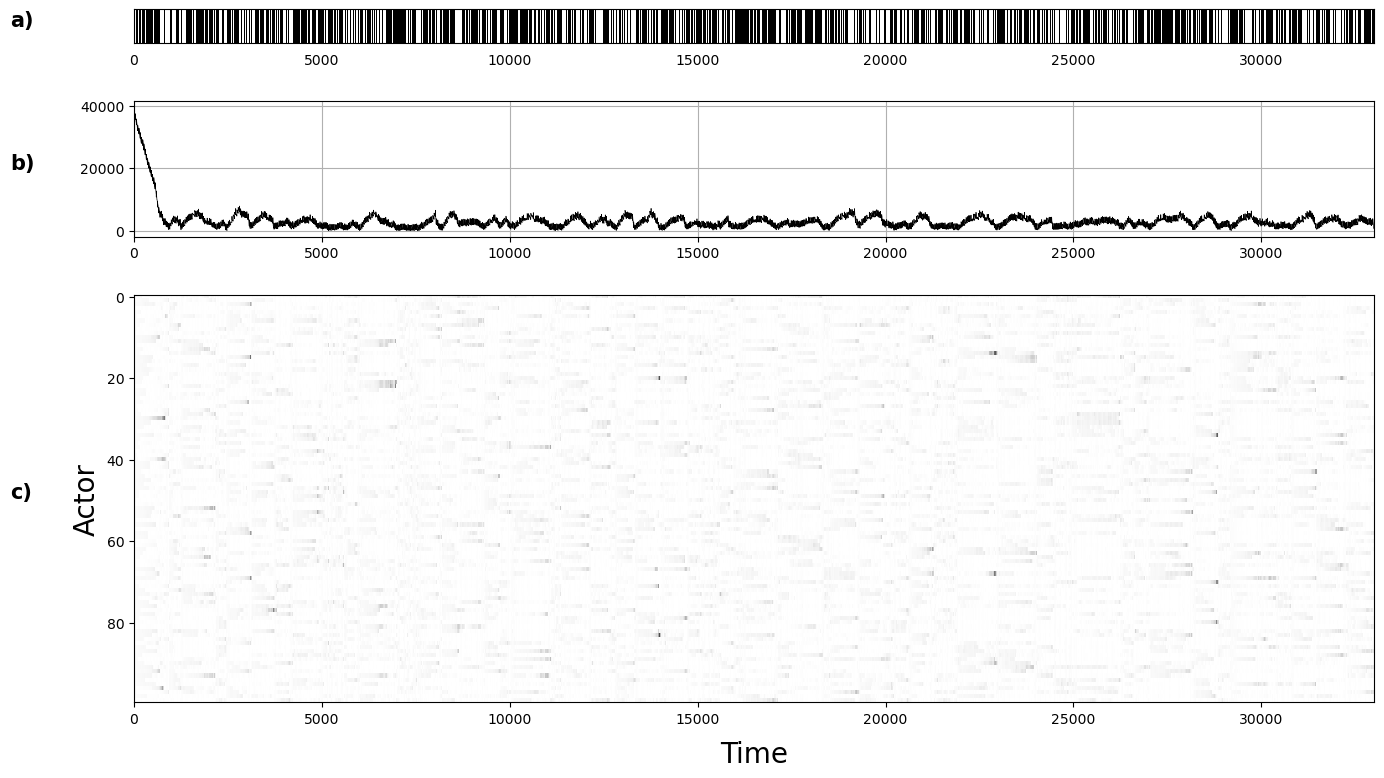

In [13]:
wealth_plot(9)

### Spatial temporal patterns

#### Standard deviation - mean field

In [14]:
def gini(t):
    N = len(t)
    numerator = np.sum(np.abs(np.subtract.outer(t, t)))
    denominator = 2 * N * np.sum(t)
    index = numerator / denominator
    return index


In [15]:
def wealth_std(num):
    std_indx = np.zeros(wealth_year.shape[1]-1)
    for i in range(wealth_year.shape[1]-1):
        wealth_year_indv = wealth_year[num, :, :]
        row_sums = np.sum(wealth_year_indv, axis=1)
        example = wealth_year_indv / row_sums[:, np.newaxis]
        std_indx[i] = np.std(example[i, :])
    
    pop_test_sum_t = np.sum(wealth_year[num, :-1, :], axis=1)
    pop_test_sum_t_plus_1 = np.sum(wealth_year[num, 1:, :], axis=1)
    result = np.divide(pop_test_sum_t_plus_1, pop_test_sum_t, out=np.zeros_like(pop_test_sum_t), where=pop_test_sum_t != 0)
    # Calculate the interquartile range (IQR) of the result
    q75, q25 = np.percentile(result[100:], [75 ,25])
    iqr = q75 - q25
    # Set a threshold for outliers (e.g., 1.5 times the IQR)
    threshold = 1.5 * iqr
    below_threshold = (result < q25 - threshold)


    # Create a grid layout with 3 rows and 1 column
    fig = plt.figure(figsize=(16, 9))
    gs = GridSpec(5, 1, height_ratios=[0.5, 1.5, 1.5, 2.2, 2.5], hspace=0.3)
    # Plot barcode representation in the top subplot
    ax1 = plt.subplot(gs[0])
    ax1.imshow([below_threshold[100:]], cmap='Greys', aspect='auto', interpolation='none')
    ax1.set_yticks([])
    ax1.tick_params(axis='x', which='both', bottom=False)
    ax1.set_xlim(0, 899)
    new_ticks = np.arange(100, 1000, 100)
    ax1.set_xticks(new_ticks - 100)  # Adjusting for the previous xlim
    ax1.set_xticklabels(new_ticks)
    ax1.text(-0.09, 0.5, "a)", transform=ax1.transAxes, size=15, weight='bold')

    # Plot line plot of np.sum(wealth_year) in the middle subplot
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(result[100:], color='blue', linewidth=0.5, markeredgecolor='black')
    #ax2.set_ylabel('W(t+1)/W(t)')
    ax2.set_xlim(0, 899)
    ax2.grid(True)
    ax2.text(-0.09, 0.5, "b)", transform=ax2.transAxes, size=15, weight='bold')
    
    ax3 = plt.subplot(gs[2], sharex = ax1)
    ax3.plot(std_indx[100:], color='green', linewidth=0.5, markeredgecolor='black')
    #ax3.set_ylabel('Standard Deviation')
    ax3.set_xlim(0, 899)
    ax3.grid(True)
    ax3.text(-0.09, 0.5, "c)", transform=ax3.transAxes, size=15, weight='bold')
    
    test = wealth_year[num,:,:]
    gini_indx = np.zeros(test.shape[0])
    for i in range(test.shape[0]):
        gini_indx[i] = gini(test[i,:])
    ax4 = plt.subplot(gs[3], sharex = ax1)
    ax4.plot(gini_indx[100:], color='red', linewidth=0.5, markeredgecolor='black')
    #ax4.set_ylabel('Gini Index')
    ax4.set_xlim(0, 899)
    ax4.grid(True)
    ax4.text(-0.09, 0.5, "d)", transform=ax4.transAxes, size=15, weight='bold')
    
    # Plot line plot of np.sum(wealth_year) in the bottom subplot
    ax5 = plt.subplot(gs[4], sharex=ax1)
    ax5.plot(np.sum(wealth_year[num, 1:, :], axis=1)[100:], color='black', linewidth=1, markeredgecolor='black')
    ax5.set_xlabel('Year', fontsize = 20)
    #ax4.set_ylabel('Global Resources')
    ax5.set_xlim(0, 899)
    ax5.grid(True)
    ax5.text(-0.09, 0.5, "e)", transform=ax5.transAxes, size=15, weight='bold')

    plt.show()

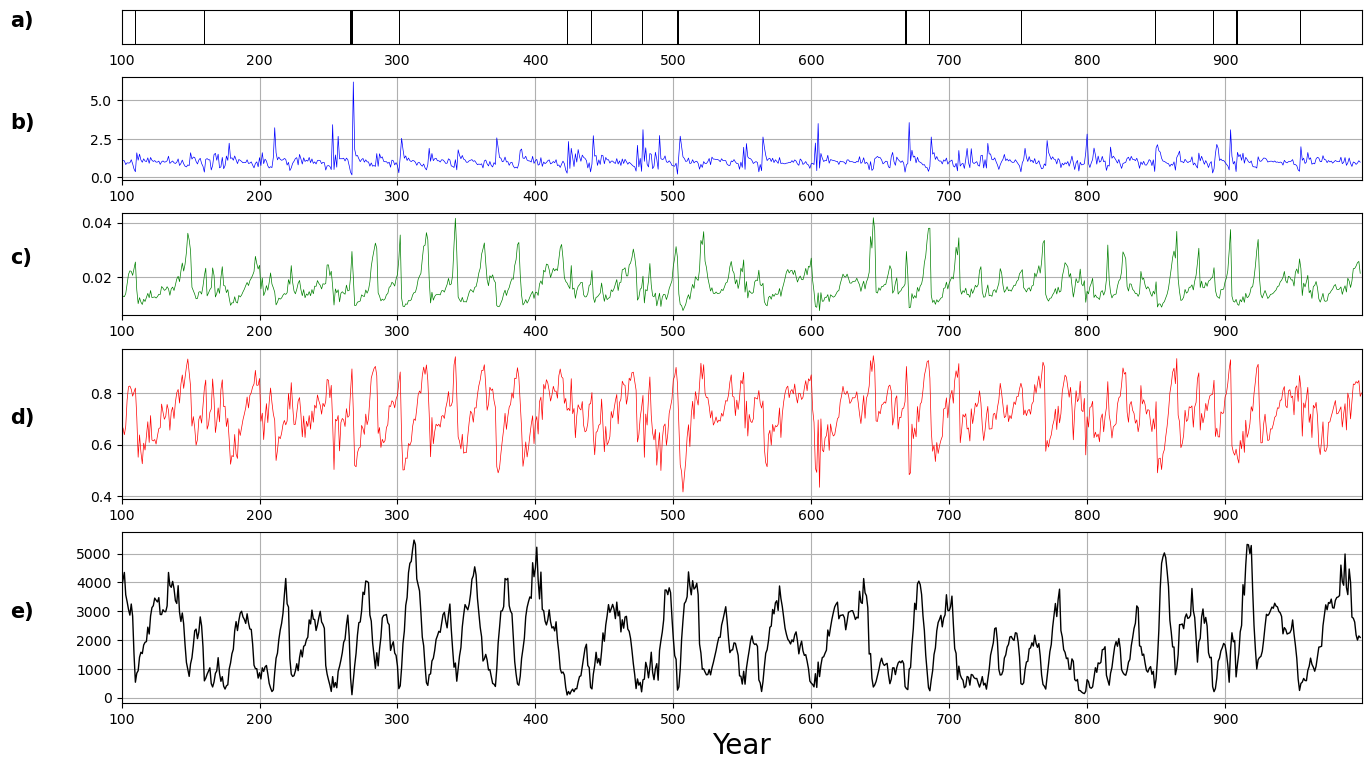

In [16]:
wealth_std(0)

### Inequality: Gini index

As mentioned befores, a decrease in global economy favors the acumulation of resources of a fewer. The gini index is an indicator of wealth distribution in a population used in economy, an index of 0 indicates a perfect equitative distributions meanwhile an index 1 indicates A high inequiality in which one agent acumulates all. In fact, in Fig we can visualize how conflicts leads inequality, since the poorer gets poorer and the richer richer. In order to quantify the inequality for those populations we discard a trasient of 500 years and average over the next 500 years, then we average over the 50 populations and we obtain:

In [18]:
gini_values = np.zeros(50)
for i in range(50):
    gini_indx = np.zeros(1000-500)
    for j in range(1000-500):
        gini_indx[j] = gini(wealth_year[i, j+500, :])
    gini_values[i] = gini_indx.mean()
    

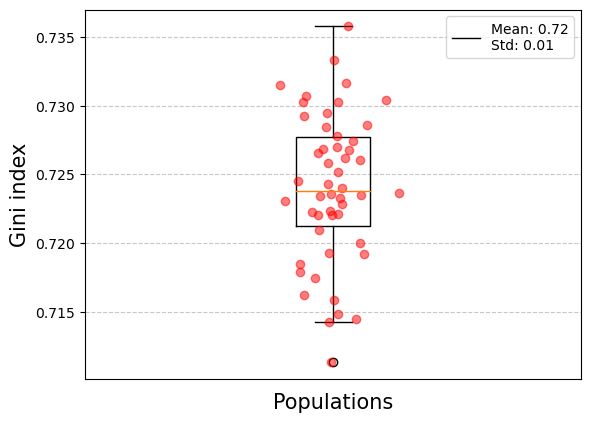

In [19]:
fig, ax = plt.subplots()

# Plot the data as a box plot
boxplot = ax.boxplot(gini_values, vert=True)
x = np.random.normal(1, 0.04, len(gini_values))
ax.plot(x, gini_values, "ro", alpha=0.5)

# Set labels and title
ax.set_ylabel("Gini index", fontsize = 15)
ax.set_xlabel("Populations", fontsize = 15, labelpad=10)
#ax.set_title("Gini Distribution")

# Show grid lines
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Add mean and standard deviation to legend
mean_value = np.mean(gini_values)
std_deviation_value = np.std(gini_values)

legend_text = f'Mean: {mean_value:.2f}\nStd: {std_deviation_value:.2f}'
ax.legend([boxplot['boxes'][0]], [legend_text], loc='upper right')

ax.set_xticks([])
# Show the plot
plt.show()


### Wealth Distribution

In [20]:
tot_wealth_actor = np.mean(wealth_year[:,500:,:], axis=1)

In [21]:
tot_wealth_actor.shape

(50, 100)

In [22]:
wealth_flat_actors = np.ravel(tot_wealth_actor)
#wealth_flat_actors_mean = np.ravel(tot_wealth_actor_mean)

### Poisson in wealth distribution

In [23]:
# Calculate the PDF using numpy.histogram
hist, bin_edges = np.histogram(wealth_flat_actors, bins='auto', density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
pdf = hist / np.sum(hist)

# Calculate the CDF and CCDF
cdf = np.cumsum(hist) / np.sum(hist)
ccdf = 1 - cdf


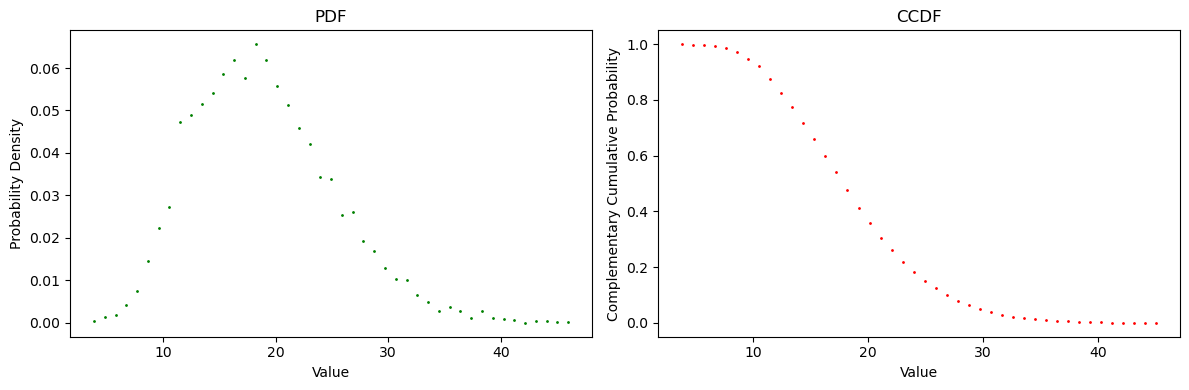

In [24]:
# Plot the PDF
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(bin_centers, pdf, color='green', marker='o', linestyle=' ', markersize=1)
#plt.xscale('log')  # Set x-axis to log scale
#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('PDF')

# Plot the CDF
plt.subplot(1, 2, 2)
plt.plot(bin_centers[:-1], ccdf[:-1], color='red', marker='o', linestyle=' ', markersize=1)
#plt.xscale('log')
#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Complementary Cumulative Probability')
plt.title('CCDF')

plt.tight_layout()
plt.show()


# Commitments

In [25]:
#positions_to_extract = [300-2, 600-2, 1000-2]
positions_to_extract = [10, 50, 100, 250, 500, 1000]
loyal_val_0 = []
# Extract values at specific positions from each matrix
for i in positions_to_extract:
    loyal_val_0.append(dataset_loyalty[i])

In [26]:
def groups(test_mtx):
    G = nx.Graph()
    G.add_nodes_from(range(len(test_mtx)))
    for i in range(len(test_mtx)):
        for j in range(len(test_mtx)):
            if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
                G.add_edge(i, j, weight=test_mtx[i, j])

    partition = community.best_partition(G)
    matrix = np.zeros((10, 10))
    # Populate the matrix based on the partition dictionary
    for node, group in partition.items():
        row = (node ) // 10  # Adjust node index to start from 0
        col = (node) % 10
        matrix[row, col] = group
    return matrix

In [27]:
groups_list = [np.zeros((10,10))]
for i in loyal_val_0:
    groups_list.append(groups(i))

In [28]:
groups_list[-1] =  1- groups_list[-1]

In [29]:
def generate_consecutive_colors(num_colors):
    colors = []
    for i in range(num_colors):
        hue = i / num_colors  # Generate hue values from 0 to 1
        saturation = 0.9  # You can adjust saturation and value to get different shades of colors
        value = 0.9
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    return colors

cluster_colors = generate_consecutive_colors(100)
random.shuffle(cluster_colors)

In [30]:
loyalty = np.stack(dataset_loyalty, axis=0)

In [31]:
loyalty.shape

(1001, 100, 100)

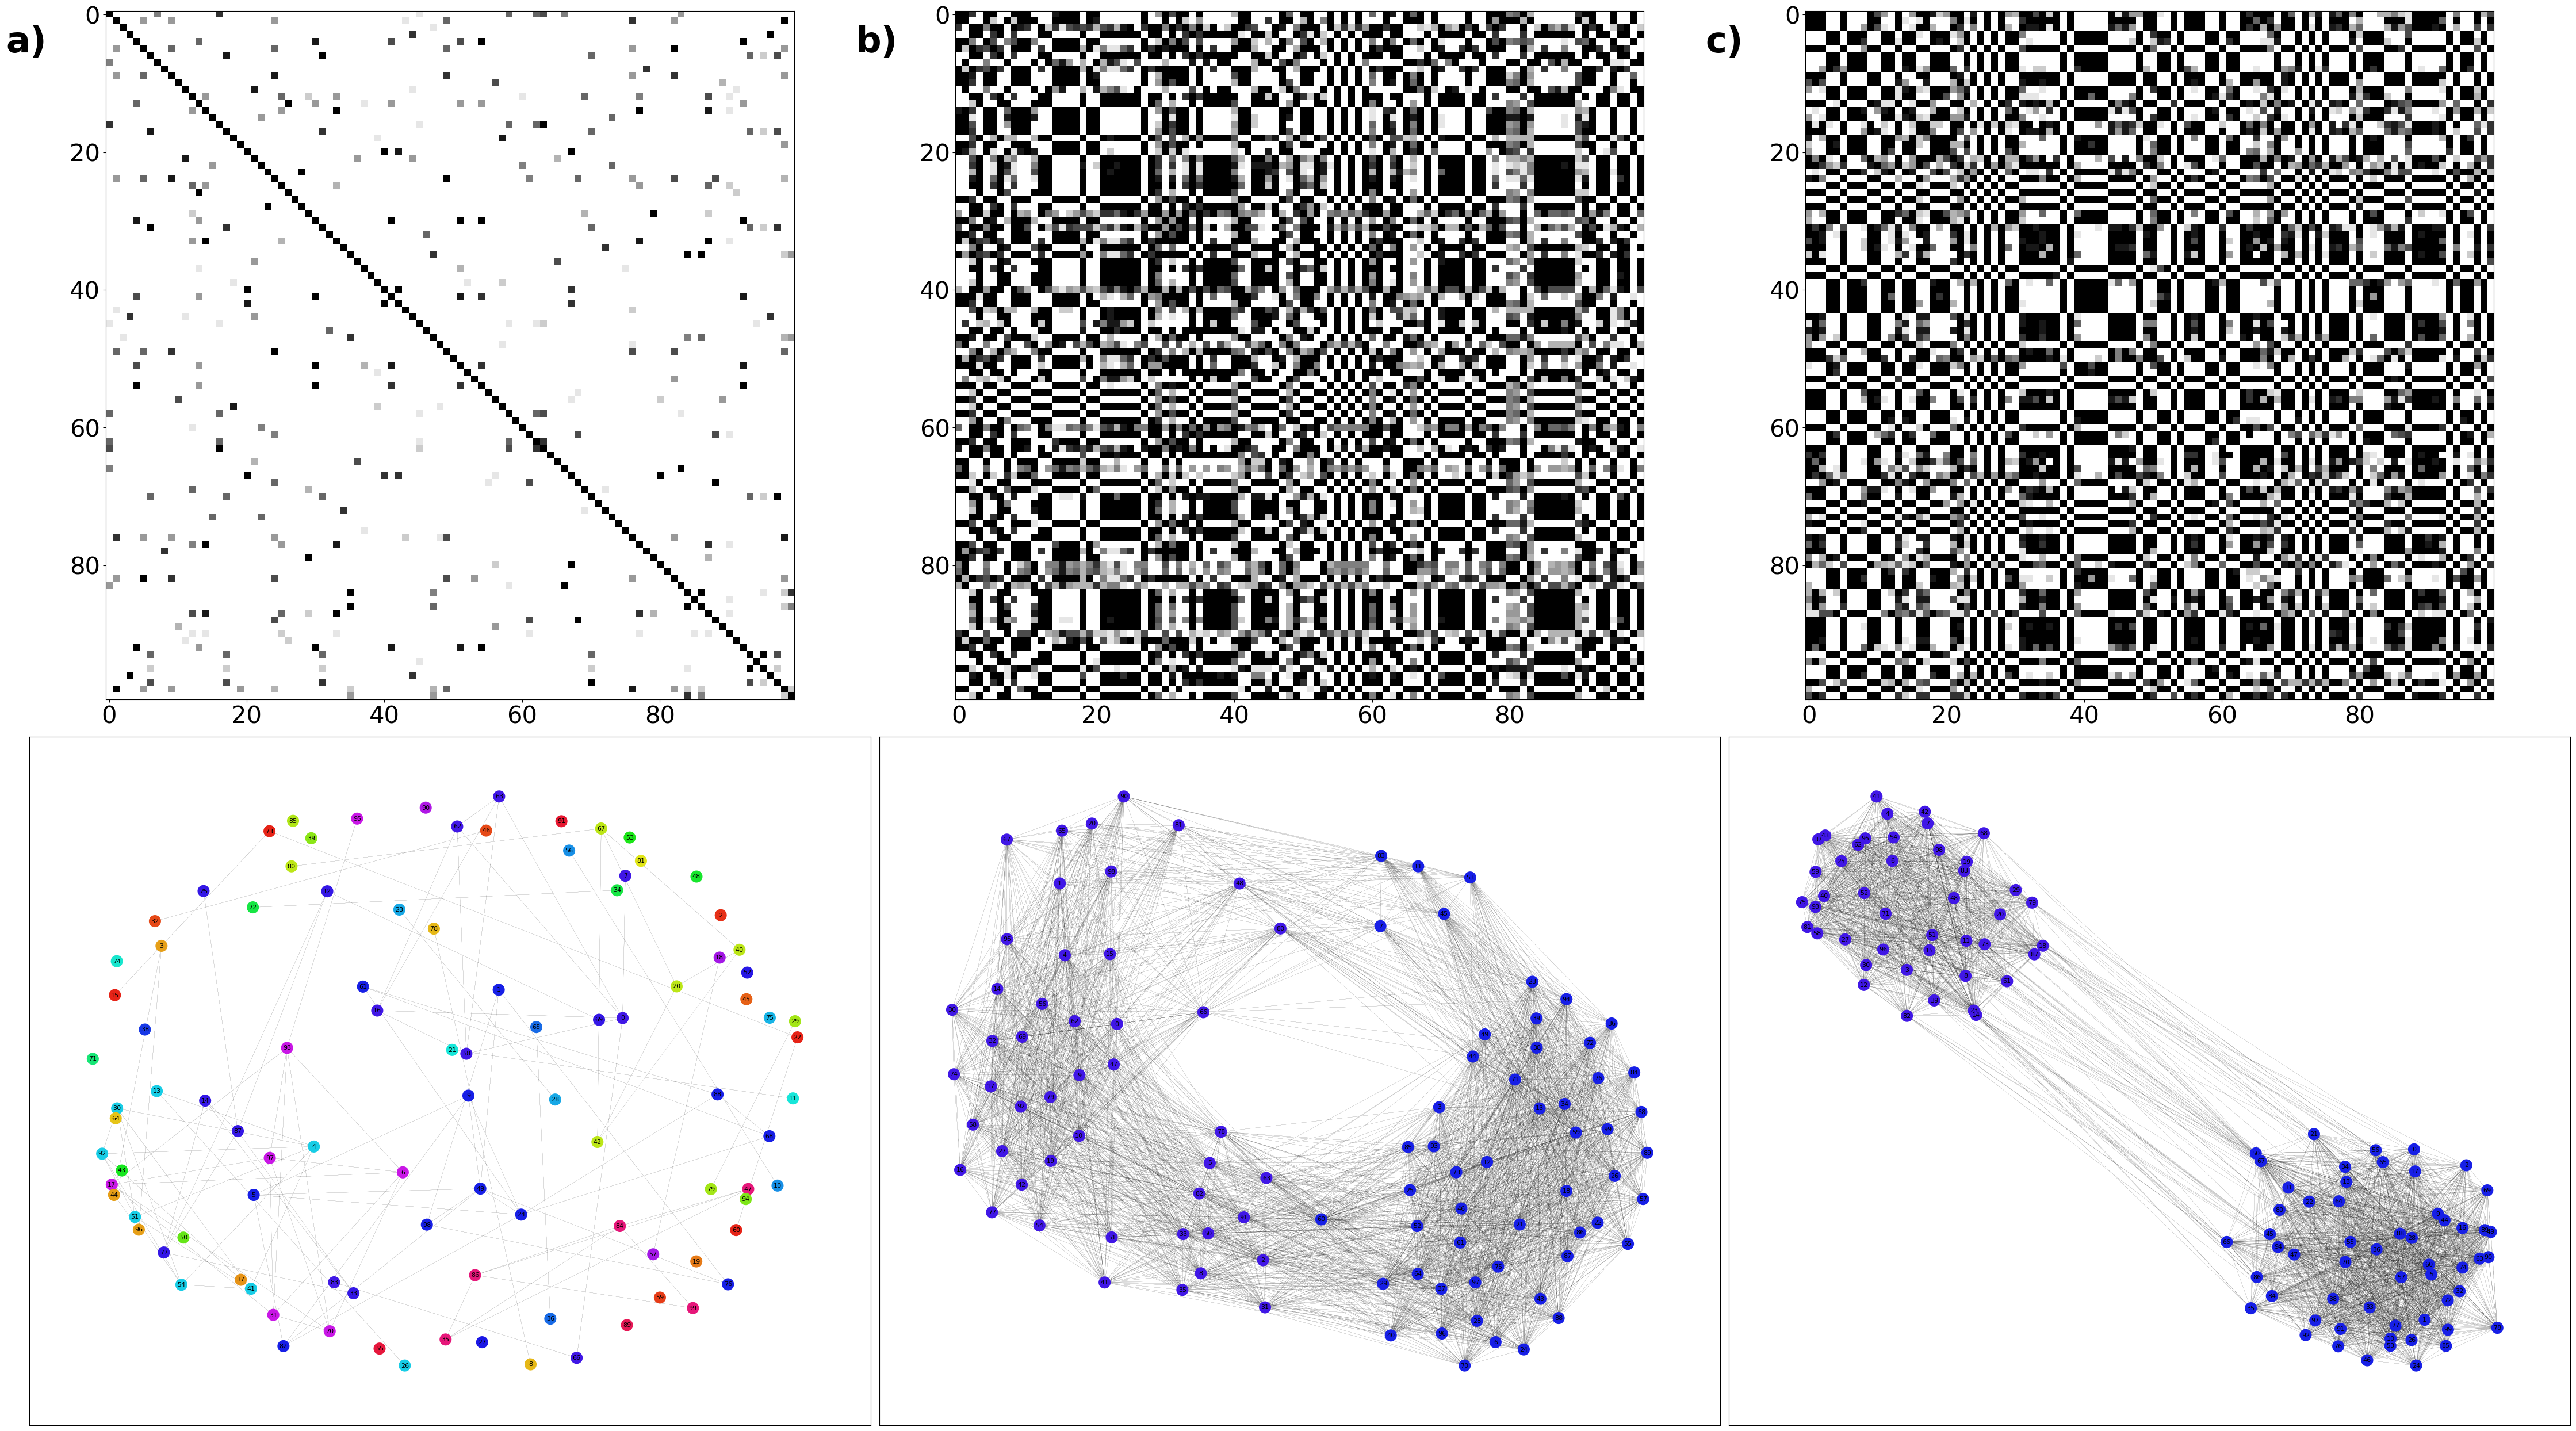

In [32]:
#cluster_colors = ['green','blue','red',]

positions_to_extract = [15, 500, 1000]
loyal_val_0 = []
# Extract values at specific positions from each matrix
for i in positions_to_extract:
    loyal_val_0.append(dataset_loyalty[i])
# First subplot: All edges
plt.figure(figsize=(45, 25))
plt.subplot(2, 3, 1)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[0], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'a)', fontsize=45, fontweight='bold')

plt.subplot(2, 3, 2)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[1], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'b)', fontsize=45, fontweight='bold')

plt.subplot(2, 3, 3)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[2], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'c)', fontsize=45, fontweight='bold')

test_mtx = loyal_val_0[0]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, k=1.9, seed=32)
node_sizes = 200
plt.subplot(2, 3, 4)  # 1 row, 2 columns, first subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)

#plt.title('Year 300', fontsize=40)

# Second subplot: Edges with weight >= 5
test_mtx = loyal_val_0[1]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, k=1.9, seed=32)
node_sizes = 200
plt.subplot(2, 3, 5)  # 1 row, 2 columns, second subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)

#plt.title('Year 600', fontsize=40)

# Second subplot: Edges with weight >= 5
test_mtx = loyal_val_0[2]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, seed=32)
node_sizes = 200
plt.subplot(2, 3, 6)  # 1 row, 2 columns, second subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)



plt.tight_layout()
plt.show()

## Conflict Sizes

In [33]:
conflict_size = []
for i in range(data.shape[0]):
    columns = ['decision', 'attacker', 'target', 'loyalty', 'Tau', 'alpha', 'Wealth_def', 'Wealth_att','path_len',"change"]
    df = pd.DataFrame(data[i,33*500:,:10], columns=columns)
    conflict_df = df[df['decision'] == 1].reset_index(drop=True)
    size_war = conflict_df[['alpha', 'Tau']].sum(axis=1)
    b = size_war.values.tolist()
    conflict_size.extend(b)

In [34]:
# Fit a power-law to the entire dataset
fit_size = powerlaw.Fit(conflict_size, xmin = 1 , xmax = 95, discrete=True)

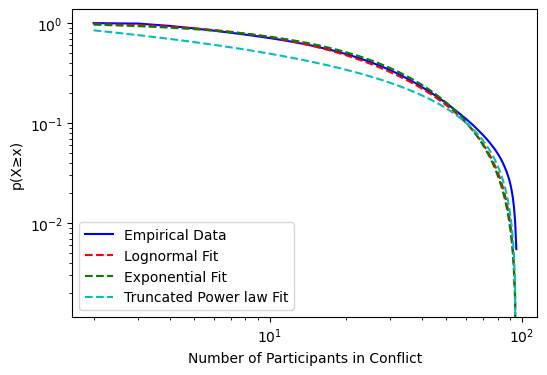

In [36]:
fig, ax = plt.subplots(figsize=(6, 4))
#fit_size.plot_pdf(color='b', label=r"Empirical Data")
#fit_size.power_law.plot_pdf(color='r', linestyle='--', ax=ax, label=r"Power law Fit")
#fit_size.lognormal.plot_pdf(color='g', linestyle='--', ax=ax, label=r"Lognormal Fit")
#fit_size.exponential.plot_pdf(color='k', linestyle='--', ax=ax, label=r"Exponential Fit")
#fit_size.truncated_power_law.plot_pdf(color='c', linestyle='--', ax=ax, label=r"Truncated Fit")

fit_size.plot_ccdf(color='b', label=r"Empirical Data")
#fit_size.power_law.plot_ccdf(color='r', linestyle='--', ax=ax, label=r"Power law Fit")
fit_size.lognormal.plot_ccdf(color='r', linestyle='--', ax=ax, label=r"Lognormal Fit")
fit_size.exponential.plot_ccdf(color='g', linestyle='--', ax=ax, label=r"Exponential Fit")
fit_size.truncated_power_law.plot_ccdf(color='c', linestyle='--', ax=ax, label=r"Truncated Power law Fit")

#FigCCDFmax.set_ylabel(u"p(X≥x)")
#FigCCDFmax.set_xlabel(r"Word Frequency")
plt.xlabel('Number of Participants in Conflict')
#plt.ylabel(u'p(X=x)')
plt.ylabel(u'p(X≥x)')
plt.legend( loc=3)

plt.show()



In [37]:
print(fit_size.distribution_compare('exponential', 'truncated_power_law', normalized_ratio=True))
print(fit_size.distribution_compare('lognormal', 'truncated_power_law', normalized_ratio=True))
print(fit_size.distribution_compare('lognormal', 'exponential', normalized_ratio=True))
print(fit_size.distribution_compare('power_law', 'lognormal', normalized_ratio=True))


(405.9947380643631, 0.0)
(467.08983466643286, 0.0)
(184.38837282662243, 0.0)
(-470.2809632464733, 0.0)


In [38]:
print(fit_size.lognormal.parameter1)  # This will print the alpha parameter
print(fit_size.lognormal.parameter2)  # This will print the lambda parameter
print(fit_size.truncated_power_law.parameter1)  # This will print the alpha parameter
print(fit_size.truncated_power_law.parameter2)  # This will print the lambda parameter

3.0848709815958117
1.168836796477564
1.0000000002853295
1.1714791327441394e-11


## Conflicts per year

In [39]:
import numpy as np
import pandas as pd

# Assuming data is your 3D array of shape (num_simulations, time_steps, features)
chunk_size = 33
conflict_num2 = []
civil_wars = []
non_civil = []
counter = 0
for sim_idx in range(data.shape[0]):
    columns = ['decision', 'attacker', 'target', 'loyalty']
    df = pd.DataFrame(data[sim_idx, 33 * 500 + 1:, :4], columns=columns)
    
    counts_civil = []
    counts_general = []
    counts_non = []
    
    size_len = 0
    for chunk_idx in range(0, len(df), chunk_size):
        size_len += chunk_size
        chunk = df.iloc[chunk_idx:chunk_idx + chunk_size]  # Select the chunk of 33 rows
        
        count_civ = len(chunk[(chunk['loyalty'] >= 5) & (chunk['decision'] == 1)])
        count_non = len(chunk[(chunk['loyalty'] < 5) & (chunk['decision'] == 1)])
        count_gen = len(chunk[chunk['decision'] == 1])
        counter += count_gen
        
        counts_civil.append(count_civ)
        counts_general.append(count_gen)
        counts_non.append(count_non)

    civil_wars.extend(counts_civil)
    conflict_num2.extend(counts_general)
    non_civil.extend(counts_non)

# Calculate frequencies
values_consecutive_cw, counts_consecutive_cw = np.unique(civil_wars, return_counts=True)
values_consecutive_g, counts_consecutive_g = np.unique(conflict_num2, return_counts=True)
values_consecutive_n, counts_consecutive_n = np.unique(non_civil, return_counts=True)

In [40]:
import numpy as np
from scipy.stats import mode, skew, kurtosis


# Total
total_conflict_num2 = np.sum(conflict_num2)
total_civil_wars = np.sum(civil_wars)
total_non_civil = np.sum(non_civil)

# Mean
mean_conflict_num2 = np.mean(conflict_num2)
mean_civil_wars = np.mean(civil_wars)
mean_non_civil = np.mean(non_civil)

# Median
median_conflict_num2 = np.median(conflict_num2)
median_civil_wars = np.median(civil_wars)
median_non_civil = np.median(non_civil)

# Mode
mode_conflict_num2 = mode(conflict_num2)
mode_civil_wars = mode(civil_wars)
mode_non_civil = mode(non_civil)

# Standard Deviation
std_conflict_num2 = np.std(conflict_num2)
std_civil_wars = np.std(civil_wars)
std_non_civil = np.std(non_civil)

# Skewness
skewness_conflict_num2 = skew(conflict_num2)
skewness_civil_wars = skew(civil_wars)
skewness_non_civil = skew(non_civil)

# Kurtosis
kurtosis_conflict_num2 = kurtosis(conflict_num2)
kurtosis_civil_wars = kurtosis(civil_wars)
kurtosis_non_civil = kurtosis(non_civil)

# Print the results
print("Total:", total_conflict_num2, total_civil_wars, total_non_civil)
print("Mean:", mean_conflict_num2, mean_civil_wars, mean_non_civil)
print("Median:", median_conflict_num2, median_civil_wars, median_non_civil)
print("Mode:", mode_conflict_num2, mode_civil_wars, mode_non_civil)
print("Standard Deviation:", std_conflict_num2, std_civil_wars, std_non_civil)
print("Skewness:", skewness_conflict_num2, skewness_civil_wars, skewness_non_civil)
print("Kurtosis:", kurtosis_conflict_num2, kurtosis_civil_wars, kurtosis_non_civil)

Total: 491220 444188 47032
Mean: 19.6488 17.76752 1.88128
Median: 20.0 18.0 2.0
Mode: ModeResult(mode=20, count=2459) ModeResult(mode=17, count=2250) ModeResult(mode=1, count=8922)
Standard Deviation: 4.003141086696796 4.193570441711931 1.394641732345623
Skewness: -0.04785898482844173 -0.10800188871432173 1.1560855342339158
Kurtosis: -0.2308312904646832 -0.2762213977680834 1.8661965897026978


# Consecutive Peace

In [44]:
consecutive_peace = []
for i in range(data.shape[0]):
    columns = ['decision', 'attacker', 'target', 'loyalty', 'Tau', 'alpha', 'Wealth_def', 'Wealth_att','path_len',"change"]
    df = pd.DataFrame(data[i,33*100+1:,:10], columns=columns)
    peace_total = [len(list(group)) for key, group in itertools.groupby(~df['decision'].eq(1)) if key]
    consecutive_peace.extend(peace_total)

In [45]:
# Calculate the PMF (Probability Mass Function) using numpy
values_consecutive_peace, counts_consecutive_peace = np.unique(consecutive_peace, return_counts=True)
pmf_consecutive_peace = counts_consecutive_peace / len(consecutive_peace)

# Calculate cumulative probabilities
cdf_consecutive_peace = np.cumsum(counts_consecutive_peace) / len(consecutive_peace)
ccdf_consecutive_peace = 1 - cdf_consecutive_peace

In [46]:
# Perform linear regression to estimate the slope
slope_ccdf_pc2, intercept_ccdf_pc2, r_value_ccdf_pc2, p_value_ccdf_pc2, std_err_ccdf_pc2 = \
linregress(values_consecutive_peace[:-1], np.log10(ccdf_consecutive_peace[:-1]))
line_ccdf_pc2 = slope_ccdf_pc2 * values_consecutive_peace[:-1] + intercept_ccdf_pc2

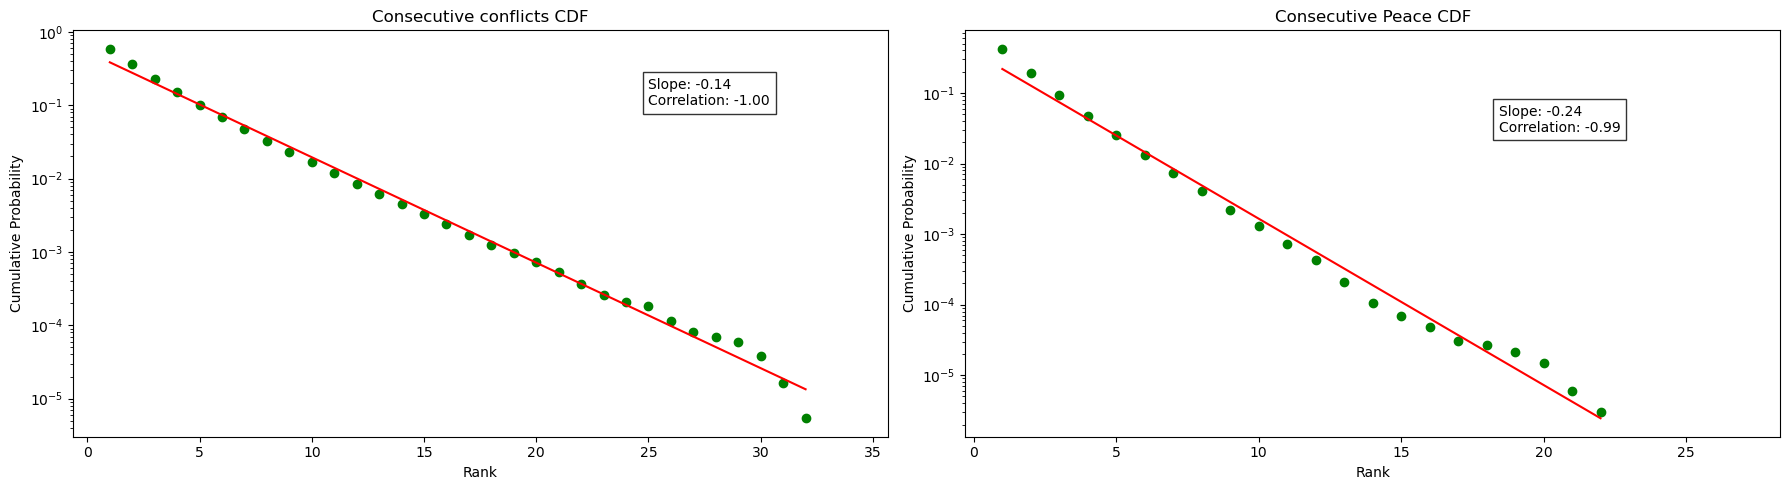

In [47]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Fourth subplot (bottom-right)
axes[0].scatter(values_consecutive_conflicts[:], ccdf_consecutive_conflicts, color='green')
axes[0].plot(values_consecutive_conflicts[:-1], 10**line_ccdf_conf2[:], color='red')
#axes[1, 1].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Rank')
axes[0].set_ylabel('Cumulative Probability')
axes[0].set_title('Consecutive conflicts CDF')
info_text1 = f'Slope: {slope_ccdf_conf2:.2f}\nCorrelation: {r_value_ccdf_conf2:.2f}'
axes[0].text(25, 0.1, info_text1, bbox=dict(facecolor='white', alpha=0.8))


# Fourth subplot (bottom-right)
axes[1].scatter(values_consecutive_peace, ccdf_consecutive_peace, color='green')
axes[1].plot(values_consecutive_peace[:-1], 10**line_ccdf_pc2[:], color='red')
#axes[1, 1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Rank')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('Consecutive Peace CDF')
info_text1 = f'Slope: {slope_ccdf_pc2:.2f}\nCorrelation: {r_value_ccdf_pc2:.2f}'
axes[1].text(1.75,0.75, info_text1, transform=axes[0].transAxes, bbox=dict(facecolor='white', alpha=0.8))


plt.tight_layout()
plt.show()
